In [63]:
from sklearn.ensemble import IsolationForest
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, pairwise_distances
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

In [64]:
dataset = ""#sklearn"

In [89]:
if "sklearn" in dataset:
    target_class = []
    breast_cancer = load_breast_cancer()
    df = pd.DataFrame(data=breast_cancer.data, columns=breast_cancer.feature_names)
    df["benign"] = breast_cancer.target
    y = df["benign"]
    X = df.drop("benign", axis=1)
    original_df = X.copy()
else:
    target_class = ['no-recurrence-events', 'recurrence-events']
    df = pd.read_csv('breast_cancer.csv', delimiter=',' , header=0,encoding='latin-1').dropna()
    X = df.loc[:, df.columns != "Class"]
    original_df = X.copy()
    y = df.loc[:, df.columns == "Class"]
    y = binary_labels = y.map(lambda x: 1 if x == 'recurrence-events' else 0)

In [72]:
df.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no,recurrence-events


In [90]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
if 'learn' not in dataset:
    # Encode categorical variables
    encod_column = {'Class': ['no-recurrence-events', 'recurrence-events'], 'age': ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79'],
    'menopause': ['lt40', 'ge40', 'premeno'], 'tumor-size': ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54'],
    'inv-nodes': ['0-2', '3-5', '6-8', '9-11', '12-14', '15-17', '18-20', '21-23', '24-26'], 'node-caps': ['yes', 'no'], 
    'deg-malig': ['1', '2', '3'], 'breast': ['left', 'right'], 'breast-quad': ['left_up', 'left_low', 'right_up', 'right_low', 'central'], 
    'irradiat': ['yes', 'no'], 'Class': ['no-recurrence-events', 'recurrence-events']}
    encoder_by_column = {}
    for column in df.columns:
        le = LabelEncoder()
        le.fit(np.array(df[column].values))
        le.classes_ = np.array(encod_column[column])
        encoder_by_column[column] = le
        df[column] = le.transform(df[column].to_list())
    #df = df.apply(lambda col: le.fit_transform(col) if col.dtype == 'object' else col)
# Perform Standard Scaling on encoded data for PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

## PCA Plot Generation

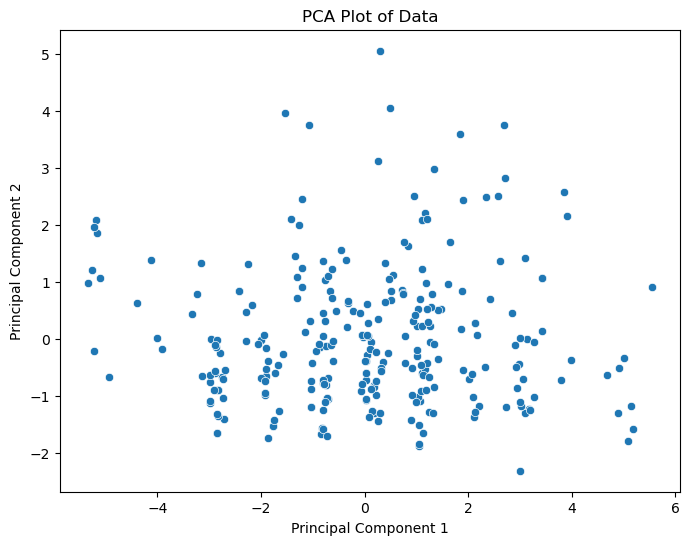

In [50]:
# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)

components = pca.fit_transform(df)

# Create a DataFrame with the reduced dimensions
components_df = pd.DataFrame(data=components, columns=['Component 1', 'Component 2'])

# Plotting
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Component 1', y='Component 2', data=components_df)
plt.title('PCA Plot of Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Confusion Matrix

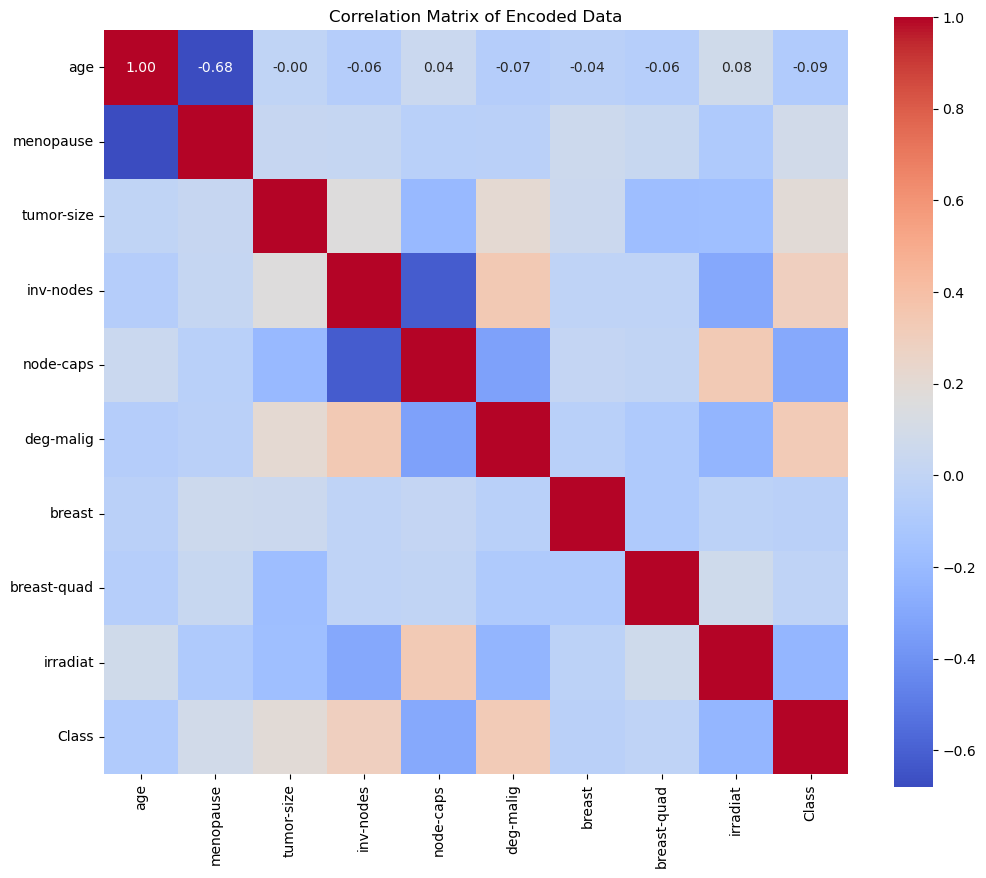

In [51]:
# Plotting the correlation matrix of the original encoded data
corr_matrix = pd.DataFrame(scaled_data, columns=df.columns).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Encoded Data')
plt.show()

## K-Means Clustering

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


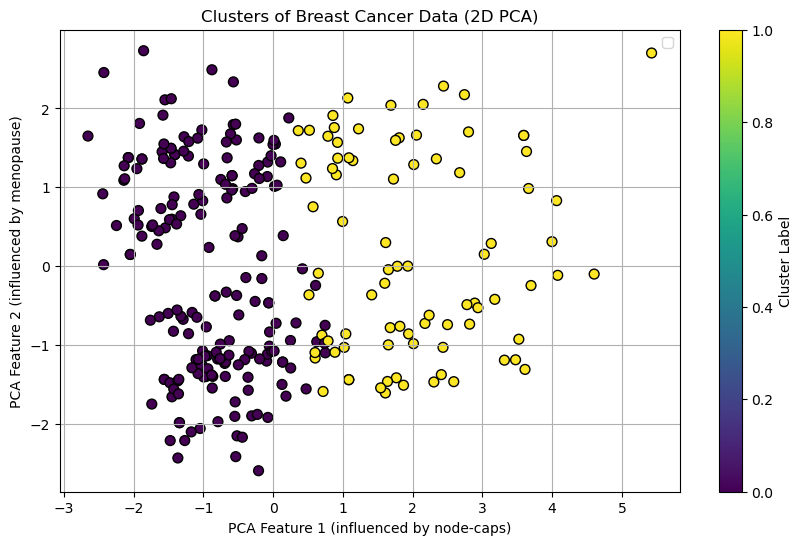

In [52]:
# Perform K-means clustering
n_clusters = 2  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
kmeans = kmeans.fit(scaled_data)
cluster_labels = kmeans.predict(scaled_data)

# Train knn on the original data to prepare asking LLM 
encoder = OneHotEncoder()
encoder.fit(original_df.values)
original_kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
original_kmeans = original_kmeans.fit(encoder.transform(original_df.values))#, y_train)

# Perform PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
components = pca.components_

# Identify the most significant features for each principal component
feature_indices = np.argsort(np.abs(components), axis=1)[:, -1]
most_significant_features = [df.columns[indices] for indices in feature_indices]

#fig, ax = plt.subplots(figsize=(10, 6))
#sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=cluster_labels, legend='full', ax=ax)

# Plotting the clusters with named PCA features
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', 
            marker='o', edgecolor='k', s=50)
plt.title('Clusters of Breast Cancer Data (2D PCA)')
plt.xlabel(f'PCA Feature 1 (influenced by {most_significant_features[0]})')
plt.ylabel(f'PCA Feature 2 (influenced by {most_significant_features[1]})')
plt.grid(True)
plt.legend()
plt.colorbar(label='Cluster Label')
plt.show()

## Hierarchical Clustering

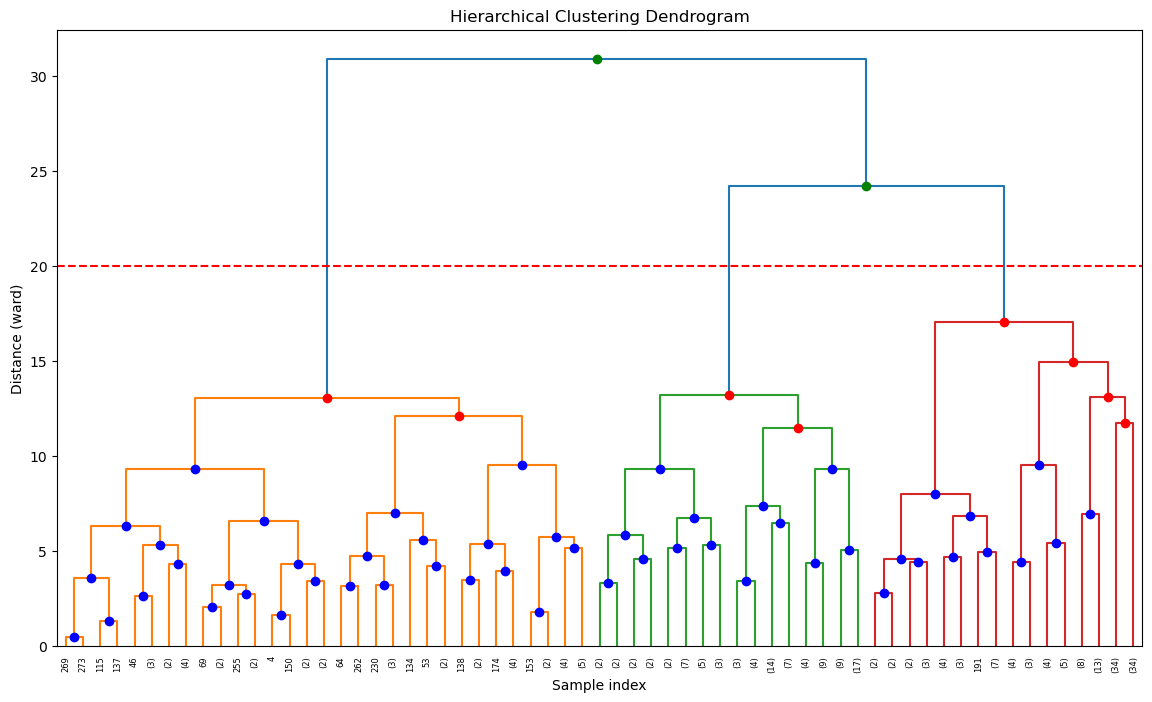

In [56]:
cluster = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
cluster_labels = cluster.fit_predict(scaled_data)

Z = linkage(scaled_data, 'ward')

def color_threshold(den, t):
    for i, d in enumerate(den['icoord']):
        x = 0.5 * sum(d[1:3])
        y = den['dcoord'][i][1]
        if y > t:
            plt.plot(x, y, 'go')
        elif y > t / 2:
            plt.plot(x, y, 'ro')
        else:
            plt.plot(x, y, 'bo')


threshold = 26 if 'learn' in dataset else 20 # adjust this based on your dataset

# Plot the dendrogram
plt.figure(figsize=(14, 8))
dendro = dendrogram(Z, color_threshold=threshold, truncate_mode='level', p=5)

# Apply the custom color function
color_threshold(dendro, threshold)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance (ward)')
plt.axhline(y=threshold, color='r', linestyle='--')

# Add annotations or adjust the aesthetics as needed
plt.show()

In [59]:
"""dendro = dendrogram(Z, color_threshold=threshold, no_plot=True)
# Plotting the clusters with named PCA features
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=dendro['leaves_color_list'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Clusters of Breast Cancer Data (2D PCA)')
plt.xlabel(f'PCA Feature 1 (influenced the most by {most_significant_features[0]})')
plt.ylabel(f'PCA Feature 2 (influenced the most by {most_significant_features[1]})')
plt.grid(True)
plt.colorbar(label='Cluster Label')
plt.show()"""

"dendro = dendrogram(Z, color_threshold=threshold, no_plot=True)\n# Plotting the clusters with named PCA features\nplt.figure(figsize=(10, 6))\nplt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=dendro['leaves_color_list'], cmap='viridis', marker='o', edgecolor='k', s=50)\nplt.title('Clusters of Breast Cancer Data (2D PCA)')\nplt.xlabel(f'PCA Feature 1 (influenced the most by {most_significant_features[0]})')\nplt.ylabel(f'PCA Feature 2 (influenced the most by {most_significant_features[1]})')\nplt.grid(True)\nplt.colorbar(label='Cluster Label')\nplt.show()"

## Gaussian Mixture Clustering

In [60]:
"""feature_x, feature_y = 0, 2

# Create a Gaussian Mixture Model with an assumption about the number of components (clusters)
# The number of components needs to be chosen or estimated
gmm = GaussianMixture(n_components=4, random_state=42)

# Fit the model and predict the cluster assignments for each data point
gmm.fit(df)
cluster_labels = gmm.predict(df)

# Optionally, we can also obtain the probabilities that each data point belongs to each cluster
cluster_probs = gmm.predict_proba(df)

# Add the cluster labels as a column in the dataframe
df['Cluster_Labels'] = cluster_labels

# Visualize the clusters (if we have at least two features to plot)
# For demonstration, we'll assume the first two features are the most relevant
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df.iloc[:, feature_x], df.iloc[:, feature_y], c=df['Cluster_Labels'], cmap='viridis', label=df['Cluster_Labels'])
plt.title('Gaussian Mixture Clustering')
plt.xlabel(f'{df.columns[feature_x]}')
plt.ylabel(f'{df.columns[feature_y]}')
plt.colorbar(scatter)
plt.show()

# Now let's print the clusters
print("Cluster labels: ", set(cluster_labels))"""

'feature_x, feature_y = 0, 2\n\n# Create a Gaussian Mixture Model with an assumption about the number of components (clusters)\n# The number of components needs to be chosen or estimated\ngmm = GaussianMixture(n_components=4, random_state=42)\n\n# Fit the model and predict the cluster assignments for each data point\ngmm.fit(df)\ncluster_labels = gmm.predict(df)\n\n# Optionally, we can also obtain the probabilities that each data point belongs to each cluster\ncluster_probs = gmm.predict_proba(df)\n\n# Add the cluster labels as a column in the dataframe\ndf[\'Cluster_Labels\'] = cluster_labels\n\n# Visualize the clusters (if we have at least two features to plot)\n# For demonstration, we\'ll assume the first two features are the most relevant\nplt.figure(figsize=(10, 6))\nscatter = plt.scatter(df.iloc[:, feature_x], df.iloc[:, feature_y], c=df[\'Cluster_Labels\'], cmap=\'viridis\', label=df[\'Cluster_Labels\'])\nplt.title(\'Gaussian Mixture Clustering\')\nplt.xlabel(f\'{df.columns[feat

# Ask LLMs

Hey, I am gonna need your help to generate explanation on the analysis of input data. To do that, I'll give you information about a dataset of cancer of radiotherapy along with kmeans clusters centers. Could you convert this information into a text that could be understandable by a layperson? 

First, help me rephrase the information in this dataset to give context: 

### Sklearn Dataset

This dataset includes 569 instances (212 - Malignant, 357 - Benign). The instances are described by 30 numeric, predictive attributes and the class. 
* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values)
* perimeter
* area
* smoothness (local variation in radius lengths)
* compactness (perimeter^2 / area - 1.0)
* concavity (severity of concave portions of the contour)
* concave points (number of concave portions of the contour)
* symmetry
* fractal dimension (“coastline approximation” - 1)

The mean, standard error, and “worst” or largest (mean of the three worst/largest values) of these features were computed for each image, resulting in 30 features. For instance, field 0 is Mean Radius, field 10 is Radius SE, field 20 is Worst Radius.


### Other Dataset

This dataset includes 201 instances of one class and 85 instances of another class. The instances are described by 9 attributes, some of which are linear and some are nominal.
* Class: no-recurrence-events, recurrence-events
* age: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99.
* menopause: lt40, ge40, premeno.
* tumor-size: 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59.
* inv-nodes: 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26, 27-29, 30-32, 33-35, 36-39.
* node-caps: yes, no.
* deg-malig: 1, 2, 3.
* breast: left, right.
* breast-quad: left-up, left-low, right-up, right-low, central.

### Feature Correlation 

Can we expect some correlation between features of this datasets? If yes, which?

### Clustering Techniques

In [57]:
for i, cluster in enumerate(original_kmeans.cluster_centers_):
    print(i, "cluster center:", encoder.inverse_transform(cluster.reshape(1, -1)))
    print('Prediction:', target_class[original_kmeans.predict(cluster.reshape(1, -1))[0]])
    print()

0 cluster center: [['40-49' 'premeno' '25-29' '0-2' 'no' 2 'left' 'left_low' 'no']]
Prediction: no-recurrence-events

1 cluster center: [['50-59' 'premeno' '30-34' '3-5' 'yes' 3 'right' 'left_low' 'yes']]
Prediction: recurrence-events



* Here's the first cluster center: [['40-49' 'premeno' '25-29' '0-2' 'no' 2 'left' 'left_low' 'no']]

Prediction: no-recurrence-events


* The second cluster center: [['50-59' 'premeno' '30-34' '3-5' 'yes' 3 'right' 'left_low' 'yes']]

Prediction: recurrence-events

### Hierarchical Clustering

In [58]:
# Retrieves the Euclidean distances between all the samples
distances = pairwise_distances(scaled_data, metric="euclidean", n_jobs=-1)

# Determines the sample indices assigned to each cluster
indices_par_cluster = []
past_clusters = set()
for label in cluster_labels:
    if label not in past_clusters:
        indices_par_cluster.append([])
        past_clusters.add(label)
    indices_par_cluster[-1].append(np.where(cluster_labels == label)[0][0])

stats_descr = {}
for idx, cluster_idx in enumerate(indices_par_cluster):
    stats_descr[f"Cluster {idx}"] = {}
    
    for i, current_col in enumerate(scaled_data.T):
        col = df.columns[i]
        mean = np.mean(current_col[cluster_idx])
        median = np.median(current_col[cluster_idx])
        stddev = np.std(current_col[cluster_idx])
        minval = np.min(current_col[cluster_idx])
        maxval = np.max(current_col[cluster_idx])
        
        stats_descr[f"Cluster {idx}"][col + "_mean"] = mean
        stats_descr[f"Cluster {idx}"][col + "_median"] = median
        stats_descr[f"Cluster {idx}"][col + "_stddev"] = stddev
        stats_descr[f"Cluster {idx}"][col + "_min"] = minval
        stats_descr[f"Cluster {idx}"][col + "_max"] = maxval

df_stats_descr = pd.DataFrame.from_dict(stats_descr)
print(df_stats_descr)

                    Cluster 0  Cluster 1     Cluster 2
age_mean            -0.637310   0.354459  1.561050e-01
age_median          -0.637310   0.354459  3.544587e-01
age_stddev           0.000000   0.000000  3.967073e-01
age_min             -0.637310   0.354459 -6.373096e-01
age_max             -0.637310   0.354459  3.544587e-01
menopause_mean       0.898280  -0.972573 -5.984028e-01
menopause_median     0.898280  -0.972573 -9.725734e-01
menopause_stddev     0.000000   0.000000  7.483412e-01
menopause_min        0.898280  -0.972573 -9.725734e-01
menopause_max        0.898280  -0.972573  8.982796e-01
tumor-size_mean     -0.883617  -0.883617 -2.549492e-01
tumor-size_median   -0.883617  -0.883617 -8.836171e-01
tumor-size_stddev    0.000000   0.000000  8.866514e-01
tumor-size_min      -0.883617  -0.883617 -8.836171e-01
tumor-size_max      -0.883617  -0.883617  9.955532e-01
inv-nodes_mean      -0.441865  -0.441865 -4.418647e-01
inv-nodes_median    -0.441865  -0.441865 -4.418647e-01
inv-nodes_

I then used a hierarchical clustering to try to identify some interesting information on each clusters about each feature distribution. Can you help me understand the results I obtained:

## Analyse Feature Distribution 

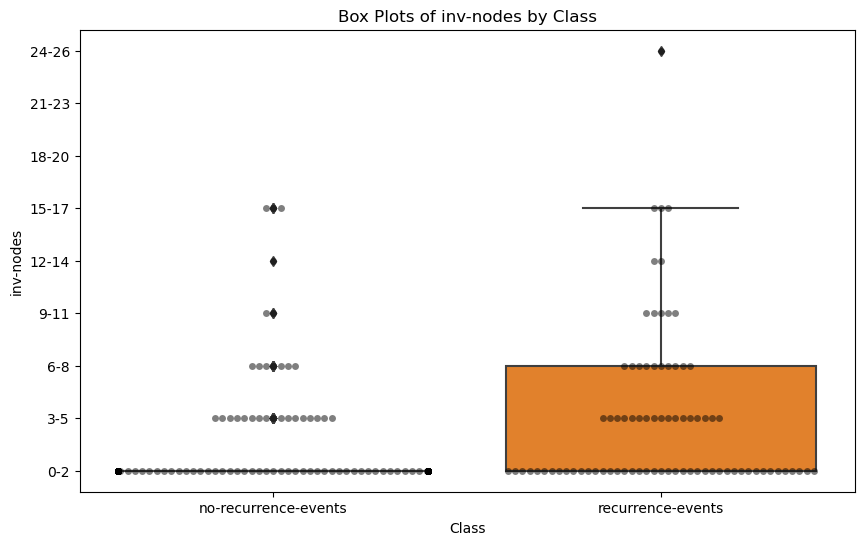

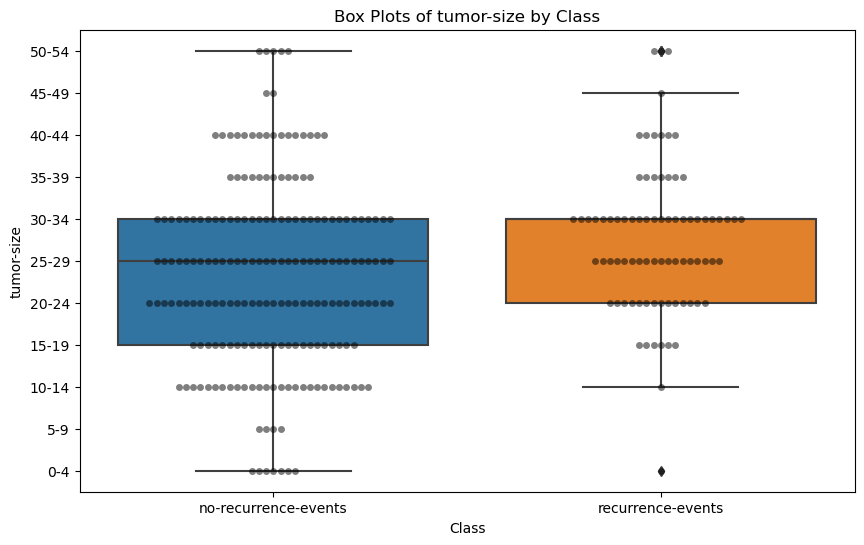

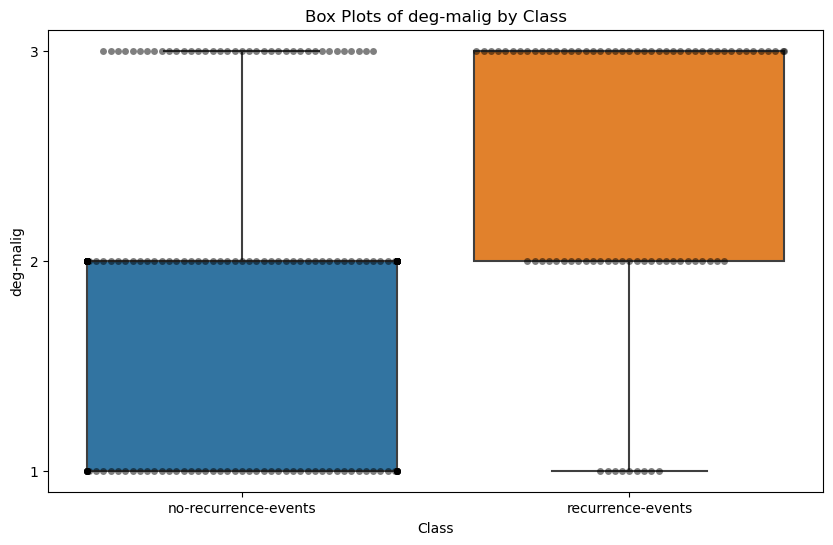

In [94]:
original_df['Class'] = df['Class']
for y_label in df.columns[:-1]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Class', y=y_label, data=df)
    sns.swarmplot(x='Class', y=y_label, data=df, color="black", alpha=0.5)

    plt.title(f'Box Plots of {y_label} by Class')
    plt.xlabel('Class')
    plt.ylabel(y_label)
    plt.xticks(np.arange(len(target_class)), target_class)
    if "learn" not in dataset:
        plt.yticks(np.arange(len(encod_column[y_label])), encod_column[y_label])
    plt.show()